# Symmetries for the first excited states.

In [2]:
import numpy as np
import h5py as hdf
import matplotlib.pyplot as plt

data_dir = "../python_data/state_symmetries/"

In [124]:
class EDResult(object):
    def __init__(self, param, datadir):
        self.datafile = datadir+"/results_{:s}_{:s}_{:d}x{:d}x{:d}.hdf5".format(param['gp'], param['ws'], *param["L"])
        self.lambdas = self.get_lambdas()
        
    def _lam_format(self, lam):
        return "_lam_{:.6f}".format(lam)
        
    def get_eigenstates(self, lam):
        """ Retrieves the eigenstates for a given lambda.
        """
        with hdf.File(self.datafile, 'r') as f:
            es = f['eigenstates'+self._lam_format(lam)][...]
        return es
    
    def get_spectrum(self, skip=["eigenstates"], cutoff=20):
        """ This used to be the `retrieve_numpy` routine.
        """
        data = {}
        lambdas = []
        with hdf.File(self.datafile, 'r') as f:
            for ds in f:
                if not any([tag in ds for tag in skip]):
                    lam = ds.split('_')[-1]
                    data[lam] = f[ds][:]
                    lambdas.append(float(lam))
        lambdas = sorted(lambdas)

        # Sort into an array and return.
        spectrum = np.zeros(shape=(len(lambdas),cutoff), dtype=np.complex) * np.nan
        for k, key in enumerate(lambdas):
            d = data['{:.6f}'.format(key)][:cutoff]
            spectrum[k,:len(d)] = d 
        return np.array(lambdas), spectrum
    
    
    def get_lambdas(self):
        """ Returns all lambdas in the file.
        """
        lambdas = []
        with hdf.File(self.datafile, 'r') as f:
            for ds in f:
                lambdas.append(float(ds.split('_')[-1]))
        return np.array(sorted(set(lambdas)))


### For comparison: plot the entire spectrum.

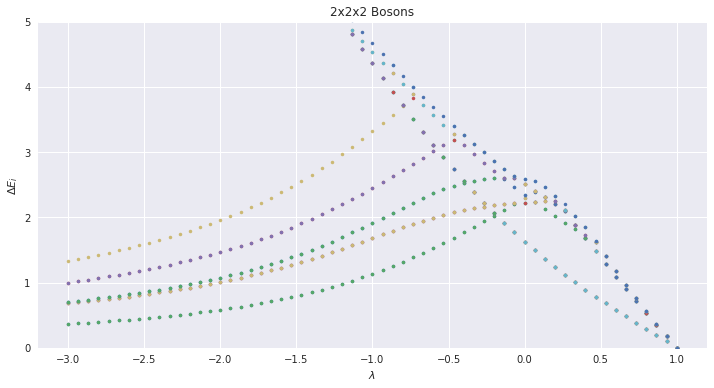

In [125]:
param = {
    'L' : [2,2,2],
    'gp' : 'bosons',
    'ws' : 'all-ws'
}
res = EDResult(param, data_dir)

n_states = 20
lams, spectrum = res.get_spectrum()

with plt.style.context('seaborn'):
    fig, bx = plt.subplots()
    fig.set_size_inches(12, 6)
    
    gs = spectrum[:,0]
    for i in range(1, n_states):
        gap = (spectrum[:,i]-gs).real
        bx.plot(lams, gap, marker='.', ls='')
        
    bx.set_xlabel('$\\lambda$')
    bx.set_ylabel('$\\Delta E_i$')
    bx.set_ylim(0, 5)
    bx.set_title('2x2x2 Bosons')
    
    fig.savefig('plots/spectrum_2x2x2_bosons.png')

### Check the cc symmetry
This can be done by flipping all links. In our convention, this merely reverses the list of the states (because this would essentially give `maxint-1`.

In [80]:
def check_cc_symmetry(state):
    if np.allclose(state, state[::-1]):
        return "+1"

    if np.allclose(state, -state[::-1]):
        return "-1"    
       
    return "indefinite"

In [50]:
for lam in [-3.0, -1.0, 0.0]:
    es = res.get_eigenstates(lam)
    print(" --- lambda = {:.6f} ---".format(lam))
    for n in [0, 1, 2, 3,4, 5, 6, 7, 8, 9, 10, 11, 12]:
        print("CC eigenvalue for state #{:d}: ".format(n), check_cc_symmetry(es[:,n]))

 --- lambda = -3.000000 ---
CC eigenvalue for state #0:  +1
CC eigenvalue for state #1:  -1
CC eigenvalue for state #2:  -1
CC eigenvalue for state #3:  -1
CC eigenvalue for state #4:  -1
CC eigenvalue for state #5:  -1
CC eigenvalue for state #6:  +1
CC eigenvalue for state #7:  +1
CC eigenvalue for state #8:  +1
CC eigenvalue for state #9:  +1
CC eigenvalue for state #10:  +1
CC eigenvalue for state #11:  -1
CC eigenvalue for state #12:  +1
 --- lambda = -1.000000 ---
CC eigenvalue for state #0:  +1
CC eigenvalue for state #1:  -1
CC eigenvalue for state #2:  -1
CC eigenvalue for state #3:  -1
CC eigenvalue for state #4:  -1
CC eigenvalue for state #5:  -1
CC eigenvalue for state #6:  +1
CC eigenvalue for state #7:  +1
CC eigenvalue for state #8:  +1
CC eigenvalue for state #9:  +1
CC eigenvalue for state #10:  +1
CC eigenvalue for state #11:  -1
CC eigenvalue for state #12:  indefinite
 --- lambda = 0.000000 ---
CC eigenvalue for state #0:  +1
CC eigenvalue for state #1:  indefinite

In [113]:
rstate_es = res.get_eigenstates(-3.0)
r_first = rstate_es[:,1]

winding_es = res.get_eigenstates(0.0)
w_first = winding_es[:,1]

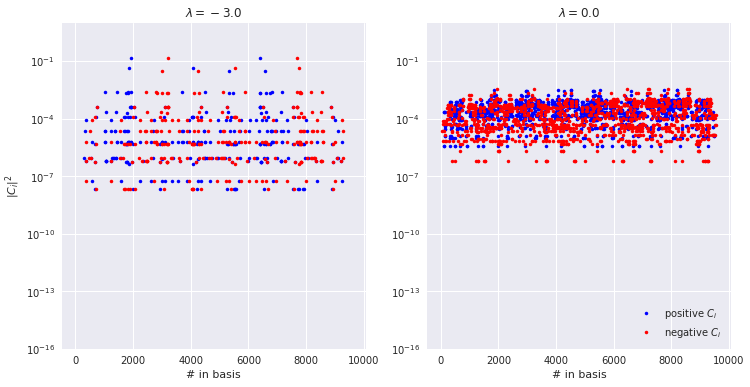

In [118]:
with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12, 6)
    
    # lam = -3.0
    rci = np.conj(r_first)*r_first
    rci[r_first<0] *= -1
    ax[0].plot(rci, ls='', marker='.', color='blue')
    ax[0].plot(-rci, ls='', marker='.', color='red')
    
    # lam = 0.0
    wci = np.conj(w_first)*w_first
    wci[w_first<0] *= -1
    ax[1].plot(wci, ls='', marker='.', color='blue', label='positive $C_i$')
    ax[1].plot(-wci, ls='', marker='.', color='red', label='negative $C_i$')
    
    for a in ax:
        a.set_yscale('log')
        a.set_ylim(1e-16, 10)
        a.set_xlabel("# in basis")
    
    ax[0].set_ylabel("$|C_i|^2$")
    ax[1].legend(loc='lower right')
    
    ax[0].set_title('$\\lambda = -3.0$')
    ax[1].set_title('$\\lambda = 0.0$')
    
    fig.savefig('plots/state_symmetry_2x2x2.png')

### Check if this is a numerical artifact.
This doesn't seem to be the case - many are different.

In [79]:
m = np.isclose(w_first, w_first[::-1], atol=0.00001)
len(w_first[~m])

2784

### Check development of weights.

In [140]:
dim_hilbert = 9600
data = np.zeros(shape=(len(res.lambdas),dim_hilbert))
for k, lam in enumerate(res.lambdas):
    es = res.get_eigenstates(lam)[:,0]
    data[k,:] = np.conj(es)*es

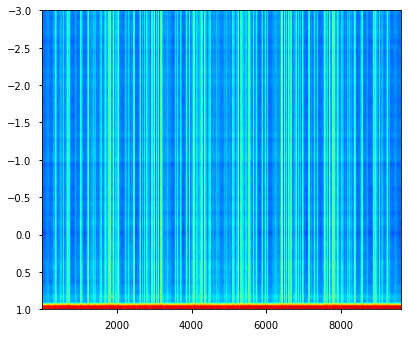

In [154]:
with plt.style.context('seaborn-notebook'):
    fig, ax = plt.subplots()
    ax.imshow(np.log10(data), cmap='jet', extent=(1,9600,1,-3), interpolation=None)
    ax.set_aspect(2000)


In [153]:
print(res.lambdas)

[-3.       -2.933333 -2.866667 -2.8      -2.733333 -2.666667 -2.6
 -2.533333 -2.466667 -2.4      -2.333333 -2.266667 -2.2      -2.133333
 -2.066667 -2.       -1.933333 -1.866667 -1.8      -1.733333 -1.666667
 -1.6      -1.533333 -1.466667 -1.4      -1.333333 -1.266667 -1.2
 -1.133333 -1.066667 -1.       -0.933333 -0.866667 -0.8      -0.733333
 -0.666667 -0.6      -0.533333 -0.466667 -0.4      -0.333333 -0.266667
 -0.2      -0.133333 -0.066667  0.        0.066667  0.133333  0.2
  0.266667  0.333333  0.4       0.466667  0.533333  0.6       0.666667
  0.733333  0.8       0.866667  0.933333  1.      ]
